A FAIRE 

- gérer les paths :


Chargement librairies 

In [1]:
import torch
from torch import nn, optim
import torchvision.models as models #modèles préentrainés de torchvision

from PIL import Image
from torchvision import transforms

import matplotlib.pyplot as plt

import os

In [2]:
current_dir = os.getcwd()

# Table des matières

- [0. Notions utiles](#0-notions-utiles)
- [1. Chargement du modèle](#1-chargement-du-modèle)
- [2. Implémentation de la loss](#2-implémentation-de-la-loss)
  - [2.1 Perte de contenu](#21-perte-de-contenu)
  - [2.2 Perte de style](#22-perte-de-style)
- [3. Sélection des images](#3-sélection-des-images)
  - [3.1 Image de contenu](#31-image-de-contenu)
  - [3.2 Image de style](#32-image-de-style)


# 0. Notions utiles



- layer : couche d'un réseau de neurone 
- feature : un filtre au sein d'une CONV layer 




Chaque couche du réseau définit généralement une banque de filtres non-linéaires dont la complexité augmente avec la profondeur dans le réseau. Ainsi, une image d’entrée $\tilde{x}$ est encodée dans chaque couche du CNN par les réponses des filtres appliqués à cette image.  

Une couche avec $N_l$ filtres distincts possède $N_l$ **feature maps**, chacune de taille $M_l$, où $M_l$ correspond au produit de la hauteur et de la largeur de la **feature maps**.  

Les réponses de la couche $l$ peuvent donc être stockées dans une matrice $F^l \in \mathbb{R}^{N_l \times M_l}$, où $F^l_{ij}$ représente l’activation du $i$-ième filtre à la position $j$ dans la couche $l$.  

Pour visualiser l’information encodée à différents niveaux de la hiérarchie (Fig. 1, reconstructions de contenu), on effectue une descente de gradient sur une image de bruit blanc afin de trouver une autre image dont les réponses aux filtres correspondent à celles de l’image originale.


## 1. Chargement du modèle 

Chargement du modèle VGG préentrainé

Le modèle va être utilisé comme extracteur de représentations visuelles 

- .features : convolution + ReLU + pooling
- . classifier : couches full-connected (classification) => non utile ici

In [3]:
vgg = models.vgg19(pretrained=True).features #charge VGG-19 pré-entrainé sur ImageNet 
vgg.eval() #met le modèle en mode évaluation --> désactive certains comportements spécifiques à l'entrainement (ex: dropout, batchnorm)


for param in vgg.parameters():
    param.requires_grad = False #empêche la mise à jour des poids du modèle durant l'entrainement

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


100%|██████████| 548M/548M [00:05<00:00, 107MB/s] 


Extracteur de features 

In [4]:
class VGGFeatures(torch.nn.Module):
    def __init__(self, vgg, layers):
        super().__init__()
        self.vgg = vgg
        self.layers = layers

    def forward(self, x):
        features = {}
        for i, layer in enumerate(self.vgg):
            x = layer(x)
            if i in self.layers:
                features[i] = x
        return features

In [5]:
#Choix des couches à utiliser 
content_layers = [21]  # par ex. conv4_2
style_layers = [0, 5, 10, 19, 28]

#Instancier l'extracteur
extractor = VGGFeatures(vgg, layers=content_layers + style_layers)

## 2. Implémentation de la loss

### 2.1 Perte de contenu :

Soient $\tilde{p}$ l’image originale et $\tilde{x}$ l’image générée, et soient $P^l$ et $F^l$ leurs représentations de caractéristiques respectives à la couche $l$. On définit alors la fonction de perte de contenu comme l’erreur quadratique entre ces deux représentations :

$$
\mathcal{L}_{\text{contenu}}(\tilde{p}, \tilde{x}, l)
= \frac{1}{2} \sum_{i,j} \left( F^l_{ij} - P^l_{ij} \right)^2.
$$

La dérivée de cette fonction de perte par rapport aux activations de la couche $l$ est donnée par :

$$
\frac{\partial \mathcal{L}_{\text{contenu}}}{\partial F^l_{ij}}
=
\begin{cases}
\left( F^l - P^l \right)_{ij} & \text{si } F^l_{ij} > 0, \\
0 & \text{si } F^l_{ij} < 0.
\end{cases}
$$



In [6]:
def content_loss(F, P):
    return torch.mean((F - P) ** 2)


### 2.2 Perte de style :

**Définition de la matrice de Gram.**  
La matrice de Gram $G^l \in \mathbb{R}^{N_l \times N_l}$ est définie de telle sorte que chaque élément $G^l_{ij}$ correspond au produit scalaire entre les cartes de caractéristiques vectorisées $i$ et $j$ de la couche $l$ :

$$
G^l_{ij} = \sum_k F^l_{ik} \, F^l_{jk}.
$$



In [7]:
def gram_matrix(x):
    b, c, h, w = x.size() # b : nombre d'images dans le batch, c : nombre de canaux, h et w : hauteur et largeur des features maps,
    features = x.view(c, h * w) #aplatit les features maps en une matrice de taille (c, h*w)
    G = torch.mm(features, features.t()) #produit matriciel
    return G 


Soient $\tilde{a}$ l’image de style originale et $\tilde{x}$ l’image générée, et soient $A^l$ et $G^l$ leurs représentations de style respectives à la couche $l$. La contribution de cette couche à la fonction de perte totale est définie par :

$$
E_l = \frac{1}{4 N_l^2 M_l^2} \sum_{i,j} \left( G^l_{ij} - A^l_{ij} \right)^2.
$$

La fonction de perte de style totale est alors donnée par :

$$
\mathcal{L}_{\text{style}}(\tilde{a}, \tilde{x}) = \sum_{l=0}^{L} w_l \, E_l,
$$

où les coefficients $w_l$ pondèrent la contribution de chaque couche à la perte totale (voir ci-dessous pour les valeurs spécifiques de $w_l$ utilisées dans nos résultats).

La dérivée de $E_l$ par rapport aux activations de la couche $l$ peut être calculée analytiquement et s’écrit :

$$
\frac{\partial E_l}{\partial F^l_{ij}}
=
\begin{cases}
\displaystyle \frac{1}{N_l^2 M_l^2}
\left( (F^l)^{\top} (G^l - A^l) \right)_{ji}
& \text{si } F^l_{ij} > 0, \\
0 & \text{si } F^l_{ij} < 0.
\end{cases}
$$

In [8]:
def style_loss(gen_features, style_grams, style_layers, weights):
    loss = 0.0
    for i, l in enumerate(style_layers):
        # Gram matrix de l'image générée à la couche l
        G = gram_matrix(gen_features[l])
        A = style_grams[l]  # Gram matrix pré-calculée de l'image de style
        
        N = gen_features[l].size(1)   # nombre de canaux
        M = gen_features[l].size(2) * gen_features[l].size(3)  # h * w = nombre de pixels par canal

        E_l = torch.sum((G - A) ** 2) / (4 * (N ** 2) * (M ** 2))
        
        loss += weights[i] * E_l
    return loss


## 3. Sélection des images 

### 3.1 Image de contenu

On charge l'image dont on veut préserver le contenu.

In [9]:
#Chargement de l'image
img_path = os.path.join(current_dir, "content_images", "joconde.jpg")
img = Image.open(img_path).convert("RGB")

#Prétraitement de l'image
size = 256
loader = transforms.Compose([
    transforms.Resize((size, size)),
    transforms.ToTensor()
])
content_image = loader(img).unsqueeze(0)  




FileNotFoundError: [Errno 2] No such file or directory: '/content/content_images/joconde.jpg'

On va également créer à partir de cette image, l'image initiale qui sera générée progressivement par le modèle

In [ ]:
#génération de l'image de bruit
generated = torch.randn_like(content_image, requires_grad=True) # requires_grad = True pour que les gradients soient calculés pour cette 
                                                                # -- variable durant la rétropropagation

Affichage de l'image de contenu

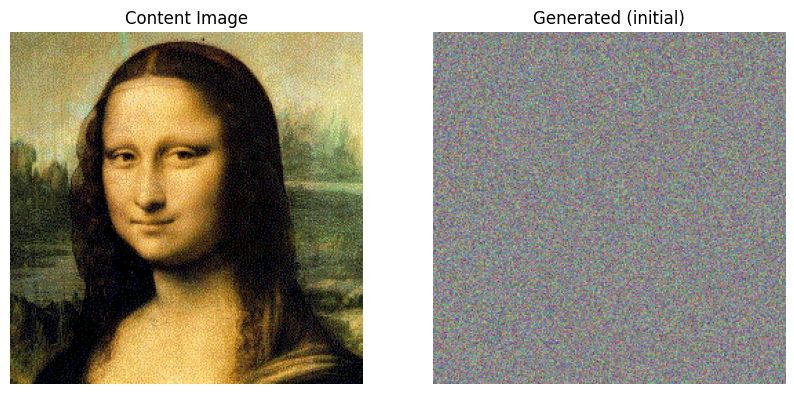

In [ ]:

def tensor_to_image(tensor):
    img = tensor.detach().cpu().squeeze(0)          # retirer batch
    img = img.permute(1,2,0)                        # (C,H,W) -> (H,W,C)
    img = (img - img.min()) / (img.max() - img.min())  # normaliser entre 0 et 1
    return img

# afficher
plt.figure(figsize=(10,5))

# Image de base
plt.subplot(1,2,1)
plt.imshow(tensor_to_image(content_image))
plt.title("Content Image")
plt.axis('off')

# Image générée (bruit)
plt.subplot(1,2,2)
plt.imshow(tensor_to_image(generated))
plt.title("Generated (initial)")
plt.axis('off')

plt.show()


### 3.2 Image de style

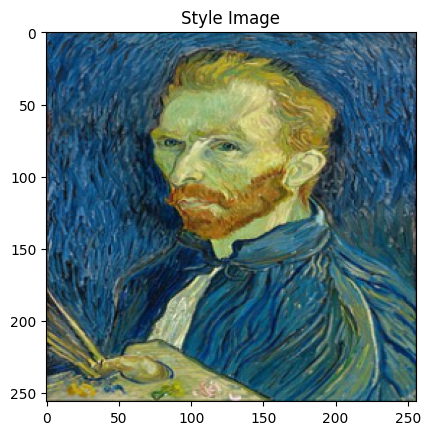

In [ ]:
#Chargement de l'image
img_path = os.path.join(current_dir, "content_images", "vangogh.jpg")
img = Image.open(img_path).convert("RGB")

#Prétraitement de l'image
size = 256
loader = transforms.Compose([
    transforms.Resize((size, size)),
    transforms.ToTensor()
])
style_image = loader(img).unsqueeze(0)  


plt.imshow(tensor_to_image(style_image))
plt.title("Style Image")


plt.show()

## 4. Optimisation

### 4.1 Paramètres d'optimisation

.... préciser les paramètres sur lesquels on peut jouer ....

In [ ]:
alpha = 1       # poids pour le contenu
beta = 1e5      # poids pour le style (souvent plus grand)

content_features = extractor(content_image)


## style
style_features = extractor(style_image)
style_grams = {l: gram_matrix(style_features[l]) for l in style_layers}

weights = [0.2, 0.2, 0.2, 0.2, 0.2]



### 4.2 Optimiseur

In [ ]:
#création d'un optimiseur qui va modifier l'image générée (bruit)
optimizer = torch.optim.LBFGS([generated])


#closure calcule la loss, les gradients et retourne la loss
def closure():
    optimizer.zero_grad() # réinitialise les gradients

    gen_features = extractor(generated) # Passer l'image générée dans le VGG + extrait les features de l'image

    # Content loss (couche choisie 21)
    loss_c = content_loss(gen_features[21], content_features[21])

    # Style loss totale pondérée avec ta fonction
    # style_loss attend : gen_features, style_grams, style_layers, weights
    loss_s = style_loss(gen_features, style_grams, style_layers, weights)

    # Loss totale : content + style
    loss = alpha * loss_c + beta * loss_s

    # Calcul des gradients
    loss.backward()

    return loss



In [ ]:
num_steps = 50  # nombre total d'itérations LBFGS
display_every = 10  # afficher tous les 50 steps

for i in range(num_steps):
    optimizer.step(closure)
    
    if (i+1) % display_every == 0:
        current_loss = closure().item()  # pour suivre la loss
        print(f"Step {i+1}, Loss: {current_loss:.4f}")
        
        # Afficher l'image générée
        plt.figure(figsize=(6,6))
        plt.imshow(tensor_to_image(generated))
        plt.axis('off')
        plt.title(f"Generated à l'étape {i+1}")
        plt.show()


Step 80, Loss: 40.9239


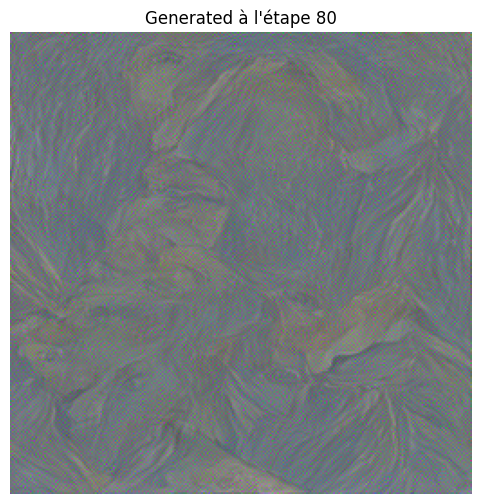

Step 120, Loss: 39.1719


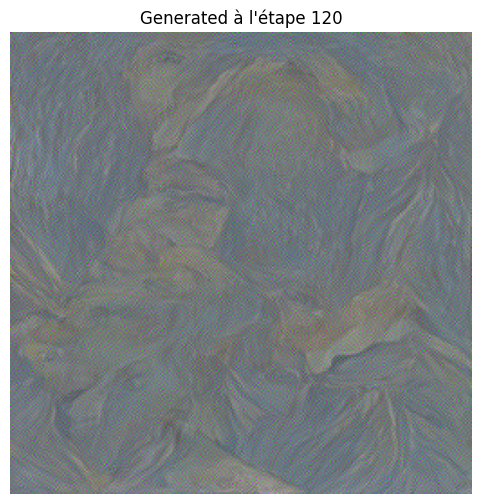

KeyboardInterrupt: 

In [ ]:
num_steps = 250  # nombre total d'itérations LBFGS
display_every = 40  # afficher tous les 50 steps

for i in range(50,num_steps):
    optimizer.step(closure)
    
    if (i+1) % display_every == 0:
        current_loss = closure().item()  # pour suivre la loss
        print(f"Step {i+1}, Loss: {current_loss:.4f}")
        
        # Afficher l'image générée
        plt.figure(figsize=(6,6))
        plt.imshow(tensor_to_image(generated))
        plt.axis('off')
        plt.title(f"Generated à l'étape {i+1}")
        plt.show()